In [1]:

import numpy as np
import pandas as pd
%matplotlib inline
import glob
import keras
from functools import reduce


Using TensorFlow backend.


In [2]:
path = r'/Users/mahnooshsadeghi/Desktop/PTSD/PTSD Data/Kalman Imputed Data' # use your path
all_files = glob.glob(path + "/*.csv")

In [3]:
participant=1
li=[]

In [4]:
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    l=df.index[df['ptsd_moment'] == 'STRESSMOMENT'].tolist()
    for i in l:
        df.ptsd_moment[i-30: i+30]= 'STRESSMOMENT'
    #df['participant']=participant
    df['windowno']= -1
    j=0
    k=1
    while j<len(df.index)-59:
        df['windowno'][j:j+60]=k
        j=j+60
        k=k+1
    df1=df.dropna(axis=0, subset=['hr'])
    df1 = df1.reset_index(drop=True)
    count =  df1.groupby('windowno', as_index=False)['hr'].size()
    for i in df1.windowno:
        if count[i]<40:
            df1=df1[df1.windowno != i ]
    df1.loc[df1.ptsd_moment != 'STRESSMOMENT', 'ptsd_moment'] = 0
    df1.loc[df1.ptsd_moment == 'STRESSMOMENT', 'ptsd_moment'] = 1
    hrmean=df1.groupby('windowno', as_index=False)['hr'].mean()
    hrmean=hrmean.rename(columns={"hr": "hrmean"})
    hrsd=df1.groupby('windowno').agg(np.std,ddof=0)['hr']
    hrsd=pd.DataFrame(hrsd)
    hrsd=hrsd.rename(columns={"hr": "hrsd"})
    stress=df1.groupby('windowno', as_index=False)['ptsd_moment'].max()
    hrmin=df1.groupby('windowno', as_index=False)['hr'].min()
    hrmin=hrmin.rename(columns={"hr": "hrmin"})
    hrmax=df1.groupby('windowno', as_index=False)['hr'].max()
    hrmax=hrmax.rename(columns={"hr": "hrmax"})
    linaccx=df1.groupby('windowno', as_index=False)['linear_accel_x'].mean()
    linaccy=df1.groupby('windowno', as_index=False)['linear_accel_y'].mean()
    linaccz=df1.groupby('windowno', as_index=False)['linear_accel_z'].mean()
    acc_x=df1.groupby('windowno', as_index=False)['acc_x'].mean()
    acc_y=df1.groupby('windowno', as_index=False)['acc_y'].mean()
    acc_z=df1.groupby('windowno', as_index=False)['acc_z'].mean()
    data=reduce(lambda x,y: pd.merge(x,y, on='windowno', how='outer'),
       [hrmean,hrmin,hrmax,hrsd,linaccx,linaccy,linaccz,acc_x,acc_y,acc_z,stress])
    data['participant']=participant
    participant=participant+1
    li.append(data)

frame = pd.concat(li, axis=0, ignore_index=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

In [46]:
frame.ptsd_moment.value_counts()


0.0    12832
1.0      512
Name: ptsd_moment, dtype: int64

In [221]:
frame.participant.value_counts()


In [48]:
frame['hrrange']= frame['hrmax']-frame['hrmin']

In [49]:
frame ['linacc']= (frame['linear_accel_x']**2+frame['linear_accel_y']**2+frame['linear_accel_z']**2)**0.5

In [50]:
export_csv = frame.to_csv (r'/Users/mahnooshsadeghi/Desktop/PTSD/PTSD Data/export_dataframe.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path



In [51]:
# Divide by class
frame0 = frame[frame['ptsd_moment'] ==0]
frame1 = frame[frame['ptsd_moment'] == 1]


In [52]:
count_class_0, count_class_1 = frame.ptsd_moment.value_counts()

In [53]:
count_class_1

512

In [54]:
frame0under = frame0.sample(3*count_class_1)
frameunder = pd.concat([frame0under, frame1], axis=0)

In [356]:
X= frameunder[['acc_x','acc_y','acc_z','linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
#X= frameunder[['acc_x','acc_y','acc_z','linear_accel_x','linear_accel_y','linear_accel_z','linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
y= frameunder[['ptsd_moment']]

In [357]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [358]:
import xgboost

In [359]:
from xgboost import XGBClassifier

In [360]:
clf= XGBClassifier ()

In [361]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [362]:
from sklearn import metrics


predictions=clf.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[437  26]
 [107  44]]


In [363]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.7833876221498371

In [364]:
from sklearn.metrics import auc

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)


In [365]:
y_preds = clf.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt


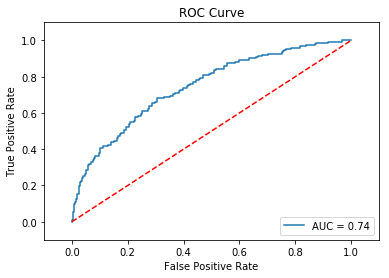

In [366]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
#It either does plot show ot plot save if you wanna save the plot make sure you don't execute plt show
plt.show()
#plt.savefig('Xgboost.png', dpi=300)

[0.11392444 0.11318599 0.13521165 0.12496798 0.1075255  0.08500999
 0.12966903 0.10355926 0.08694618]


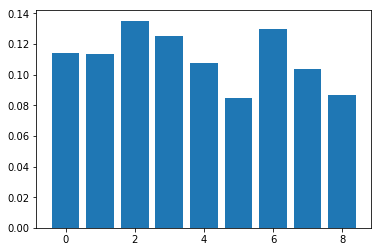

In [367]:
# plot feature importance
print(clf.feature_importances_)
pyplot.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
pyplot.show()

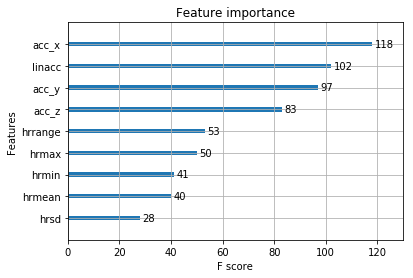

In [370]:
# plot feature importance
from xgboost import plot_importance
plot_importance(clf)
#plt.show()
plt.savefig('FeatureImportanceXgboost.png', dpi=200)

In [129]:
frame

In [130]:
#df1

In [159]:
#dropping missing values in frame 1 to avoid bias: Just one window from the PTSD moments are dropped

frame_no_missing = frame.dropna()

In [160]:
frame_no_missing .ptsd_moment.value_counts()

0.0    12798
1.0      511
Name: ptsd_moment, dtype: int64

In [161]:
frame_no_missing0 = frame_no_missing[frame_no_missing['ptsd_moment'] ==0]
frame_no_missing1 = frame_no_missing[frame_no_missing['ptsd_moment'] == 1]

In [162]:
count_class_0, count_class_1 = frame_no_missing.ptsd_moment.value_counts()

In [163]:
count_class_1

511

In [164]:
frame0under = frame_no_missing0.sample(3*count_class_1)
frameunder = pd.concat([frame0under, frame_no_missing1], axis=0)

In [371]:
X= frameunder[['acc_x','acc_y','acc_z','linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
#X= frameunder[['linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
y= frameunder[['ptsd_moment']]

In [372]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [373]:
#######SVM
from sklearn.svm import SVC

svc_model=SVC(probability=True, random_state=10)


In [374]:
svc_model.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=10,
  shrinking=True, tol=0.001, verbose=False)

In [375]:
predictions=svc_model.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[456   7]
 [135  16]]


In [376]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.7687296416938111

In [377]:
from sklearn.metrics import auc

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [378]:
y_preds = svc_model.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt

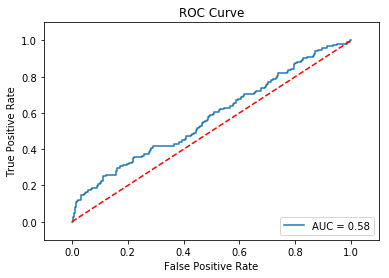

<Figure size 432x288 with 0 Axes>

In [379]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()
plt.savefig('svm.png', dpi=300)

In [380]:
###Logistic regression for windows


from sklearn.linear_model import LogisticRegression
lr_model= LogisticRegression(solver='lbfgs')
lr_model.fit(X_train,y_train)

from sklearn import metrics
predictions=lr_model.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[440  23]
 [119  32]]


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [381]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.7687296416938111

In [382]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [383]:
y_preds = lr_model.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt

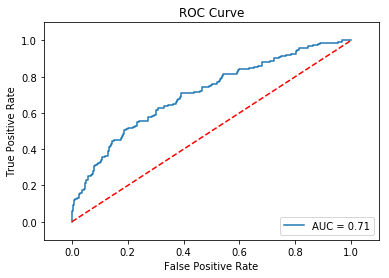

In [384]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()
#plt.savefig('logistic.png', dpi=300)

In [385]:
from sklearn.ensemble import RandomForestClassifier

In [386]:
clf= RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=10)

In [387]:
clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [388]:
predictions=clf.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[427  36]
 [109  42]]


In [389]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.7638436482084691

In [390]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [391]:
y_preds = clf.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt

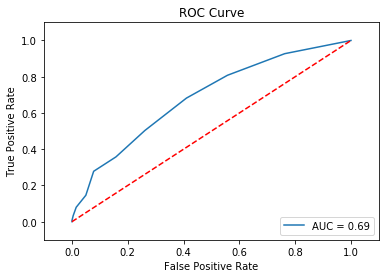

In [392]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
#plt.show()
plt.savefig('RandomForest.png', dpi=300)

In [393]:
#Naive bayes doesnt work well

from sklearn.naive_bayes import GaussianNB

In [394]:
clf=GaussianNB()

In [395]:
clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [396]:
predictions=clf.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[407  56]
 [ 97  54]]


In [397]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.750814332247557

In [398]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [399]:
y_preds = clf.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt

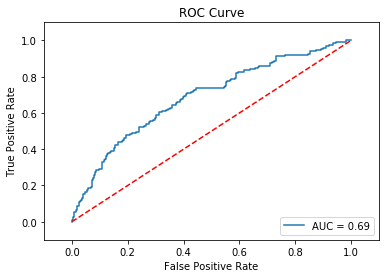

In [229]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

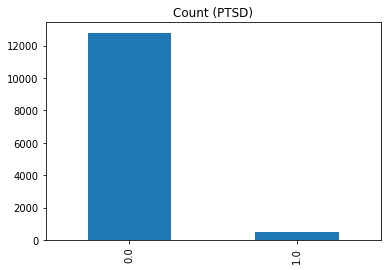

In [242]:
frame_no_missing['ptsd_moment'].value_counts().plot(kind='bar', title='Count (PTSD)')
plt.savefig('ImbalancedData.png', dpi=300)
